In [1]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#read test data and turn it into data frame
import mat4py

#remember to change the file path
test_data = mat4py.loadmat("C:/Users/brian/Desktop/AI_intro/final_class/devkit/devkit/cars_test_annos_withlabels.mat")
test_df = pd.DataFrame(test_data['annotations'])

test_df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,30,52,246,147,181,00001.jpg
1,100,19,576,203,103,00002.jpg
2,51,105,968,659,145,00003.jpg
3,67,84,581,407,187,00004.jpg
4,140,151,593,339,185,00005.jpg


In [3]:
#read train data and turn it into data frame
train_data = mat4py.loadmat("C:/Users/brian/Desktop/AI_intro/final_class/devkit/devkit/cars_train_annos.mat")
train_df = pd.DataFrame(train_data['annotations'])

train_df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg


In [4]:
#add path into data frame
path = 'C:/Users/brian/Desktop/AI_intro/final_class/'

train_dir = path + 'cars_train/'
test_dir = path + 'cars_test/'

train_cases = glob.glob(train_dir + '*jpg')
test_cases = glob.glob(test_dir + '*jpg')

train_cases = [x.replace('\\','/') for x in train_cases]
test_cases = [x.replace('\\','/') for x in test_cases]

train_df['path'] = train_cases
test_df['path'] = test_cases

In [5]:
#data augmentation
def adjust_data(path, x1, y1, x2, y2):
    im = cv2.imread(path)
    img = im[y1:y2, x1:x2]
    img = cv2.resize(img, (224,224), interpolation=cv2.INTER_NEAREST)
    img = np.reshape(img, (224,224,3))
    return img

def compose_data(df):
    data = []
    labels = []
    
    for ind in df.index:
        x1 = df['bbox_x1'][ind]
        x2 = df['bbox_x2'][ind]
        y1 = df['bbox_y1'][ind]
        y2 = df['bbox_y2'][ind]
        path = df['path'][ind]
        label = df['class'][ind]
        
        data.append(adjust_data(path,x1,y1,x2,y2))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [6]:
x_train, y_train = compose_data(train_df)
x_test, y_test = compose_data(test_df)

In [7]:
#image data generator
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = False,
    vertical_flip = False
)

datagen.fit(x_train)

In [8]:
#one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
#AlexNet
AlexNet = Sequential()

#1st convolutional layer
AlexNet.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), activation='relu', padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#2nd convolutional layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd convolutional layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
AlexNet.add(BatchNormalization())

#4th convolutional layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
AlexNet.add(BatchNormalization())

#5th convolutional layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#pass to a fully connected layer
AlexNet.add(Flatten())

#1st fully connected layer
AlexNet.add(Dense(4096, activation='relu'))
AlexNet.add(BatchNormalization())
#add dropout
AlexNet.add(Dropout(0.4))

#2nd fully connected layer
AlexNet.add(Dense(4096, activation='relu'))
AlexNet.add(BatchNormalization())
#add dropout
AlexNet.add(Dropout(0.4))

#3rd fully connected layer
AlexNet.add(Dense(1000, activation='relu'))
AlexNet.add(BatchNormalization())
#add dropout
AlexNet.add(Dropout(0.4))

#output layer
AlexNet.add(Dense(197, activation='softmax'))

#optimizer
optimizer = Adam(lr=0.0001, decay=1e-5)
AlexNet.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#callback
callback = EarlyStopping(monitor='loss', patience=7)

In [38]:
#fit the model
history = AlexNet.fit(datagen.flow(x_train,y_train,batch_size=10), validation_data=(x_test, y_test), epochs=30, verbose=1, callbacks=[callback])

Epoch 1/30
815/815 [==============================] - 769s 937ms/step - loss: 6.1620 - accuracy: 0.0104 - val_loss: 6.4110 - val_accuracy: 0.0206
Epoch 2/30
815/815 [==============================] - 776s 949ms/step - loss: 5.7898 - accuracy: 0.0147 - val_loss: 5.8508 - val_accuracy: 0.0220
Epoch 3/30
815/815 [==============================] - 774s 947ms/step - loss: 5.6006 - accuracy: 0.0194 - val_loss: 5.3821 - val_accuracy: 0.0354
Epoch 4/30
815/815 [==============================] - 776s 949ms/step - loss: 5.4764 - accuracy: 0.0212 - val_loss: 5.3765 - val_accuracy: 0.0381
Epoch 5/30
815/815 [==============================] - 776s 950ms/step - loss: 5.3327 - accuracy: 0.0291 - val_loss: 5.4600 - val_accuracy: 0.0284
Epoch 6/30
815/815 [==============================] - 778s 952ms/step - loss: 5.2267 - accuracy: 0.0344 - val_loss: 5.4961 - val_accuracy: 0.0461
Epoch 7/30
815/815 [==============================] - 775s 949ms/step - loss: 5.1053 - accuracy: 0.0402 - val_loss: 4.7998 -

KeyboardInterrupt: 

In [13]:
#save the model
AlexNet.save("AlexNet")

INFO:tensorflow:Assets written to: AlexNet\assets


In [16]:
#load the model
from keras.models import load_model
AlexNet = load_model("C:/Users/brian/Desktop/AI_intro/final_class/AlexNet")

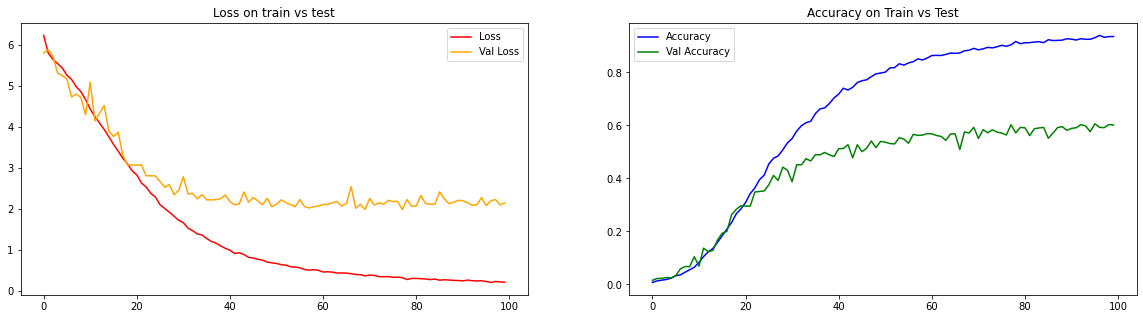

In [35]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on Train vs Test')
plt.legend(loc='best')

plt.show()

In [11]:
from keras.applications import mobilenet_v2

mobile = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
optimizer = Adam(lr=0.0001, decay=1e-5)
callback = EarlyStopping(monitor='loss', patience=7)
checkpoint = ModelCheckpoint(filepath="C:/Users/brian/Desktop/AI_intro/final_class/Mobile", save_best_only=True)

mobile.trainable = True
for i,layer in enumerate(mobile.layers):
    layer.trainable = True

x = mobile.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
output_layer = Dense(197, activation='softmax', name='softmax')(x)

mobilev2 = Model(inputs=mobile.input, outputs=output_layer)
mobilev2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [9]:
from keras.applications import resnet
from keras.models import Model

res = resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3))

optimizer = Adam(lr=0.0001, decay=1e-5)
callback = EarlyStopping(monitor='loss', patience=7)
checkpoint = ModelCheckpoint(filepath="C:/Users/brian/Desktop/AI_intro/final_class/ResNet", save_best_only=True)

x = res.output
x = Flatten()(x)
x = Dropout(0.4)(x)
output_layer = Dense(197, activation='softmax', name='softmax')(x)

res50 = Model(inputs=res.input, outputs=output_layer)
res50.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

94781440/94765736 [==============================] - 26s 0us/step


In [12]:
mobile_history = mobilev2.fit(datagen.flow(x_train,y_train,batch_size=16), validation_data=(x_test, y_test), epochs=100, verbose=1, callbacks=[callback, checkpoint])

Epoch 1/100
509/509 [==============================] - 678s 1s/step - loss: 13.7796 - accuracy: 0.0397 - val_loss: 11.0720 - val_accuracy: 0.0757
Epoch 2/100
509/509 [==============================] - 684s 1s/step - loss: 8.6797 - accuracy: 0.2538 - val_loss: 7.1106 - val_accuracy: 0.3551
Epoch 3/100
509/509 [==============================] - 697s 1s/step - loss: 5.8299 - accuracy: 0.5208 - val_loss: 5.1380 - val_accuracy: 0.5655
Epoch 4/100
509/509 [==============================] - 702s 1s/step - loss: 4.2309 - accuracy: 0.6792 - val_loss: 3.9280 - val_accuracy: 0.6696
Epoch 5/100
509/509 [==============================] - 688s 1s/step - loss: 3.1621 - accuracy: 0.7705 - val_loss: 3.0247 - val_accuracy: 0.7468
Epoch 6/100
509/509 [==============================] - 688s 1s/step - loss: 2.4099 - accuracy: 0.8320 - val_loss: 2.3490 - val_accuracy: 0.7871
Epoch 7/100
509/509 [==============================] - 700s 1s/step - loss: 1.8618 - accuracy: 0.8712 - val_loss: 1.9971 - val_accurac

Epoch 32/100
509/509 [==============================] - 803s 2s/step - loss: 0.2004 - accuracy: 0.9872 - val_loss: 0.7122 - val_accuracy: 0.8552
Epoch 33/100
509/509 [==============================] - 797s 2s/step - loss: 0.2026 - accuracy: 0.9859 - val_loss: 0.7301 - val_accuracy: 0.8511
Epoch 34/100
509/509 [==============================] - 793s 2s/step - loss: 0.1966 - accuracy: 0.9860 - val_loss: 0.7519 - val_accuracy: 0.8459
Epoch 35/100
509/509 [==============================] - 798s 2s/step - loss: 0.1980 - accuracy: 0.9849 - val_loss: 0.7299 - val_accuracy: 0.8574
Epoch 36/100
509/509 [==============================] - 796s 2s/step - loss: 0.2024 - accuracy: 0.9835 - val_loss: 0.7292 - val_accuracy: 0.8547
Epoch 37/100
509/509 [==============================] - 813s 2s/step - loss: 0.1765 - accuracy: 0.9899 - val_loss: 0.7041 - val_accuracy: 0.8559
Epoch 38/100
509/509 [==============================] - 776s 2s/step - loss: 0.1751 - accuracy: 0.9877 - val_loss: 0.7229 - val_ac

In [ ]:
res_history = res50.fit(datagen.flow(x_train,y_train,batch_size=16), validation_data=(x_test, y_test), epochs=100, verbose=1, callbacks=[callback, checkpoint])

Epoch 1/100
509/509 [==============================] - 1819s 4s/step - loss: 4.9575 - accuracy: 0.1505 - val_loss: 2.5139 - val_accuracy: 0.4008
Epoch 2/100
509/509 [==============================] - 2098s 4s/step - loss: 1.5415 - accuracy: 0.6159 - val_loss: 1.6144 - val_accuracy: 0.6014
Epoch 3/100
509/509 [==============================] - 3495s 7s/step - loss: 0.7442 - accuracy: 0.8012 - val_loss: 1.7378 - val_accuracy: 0.6209
Epoch 4/100
509/509 [==============================] - 3608s 7s/step - loss: 0.4717 - accuracy: 0.8709 - val_loss: 1.9568 - val_accuracy: 0.6022
Epoch 5/100
509/509 [==============================] - 3499s 7s/step - loss: 0.3650 - accuracy: 0.8971 - val_loss: 1.6745 - val_accuracy: 0.6587
Epoch 6/100
509/509 [==============================] - 3495s 7s/step - loss: 0.3054 - accuracy: 0.9148 - val_loss: 1.8248 - val_accuracy: 0.6459
Epoch 7/100
509/509 [==============================] - 3507s 7s/step - loss: 0.2775 - accuracy: 0.9225 - val_loss: 1.6001 - val_ac

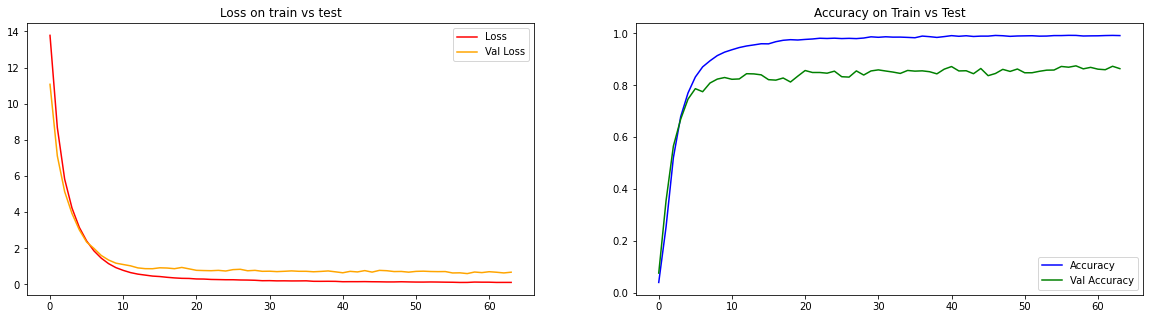

In [13]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.lineplot(x=mobile_history.epoch, y=mobile_history.history['loss'], color='red', label='Loss')
sns.lineplot(x=mobile_history.epoch, y=mobile_history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

plt.subplot(1,2,2)
sns.lineplot(x=mobile_history.epoch, y=mobile_history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=mobile_history.epoch, y=mobile_history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on Train vs Test')
plt.legend(loc='best')

plt.show()

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.lineplot(x=res_history.epoch, y=res_history.history['loss'], color='red', label='Loss')
sns.lineplot(x=res_history.epoch, y=res_history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

plt.subplot(1,2,2)
sns.lineplot(x=res_history.epoch, y=res_history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=res_history.epoch, y=res_history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on Train vs Test')
plt.legend(loc='best')

plt.show()